Visualizing Feature Maps using PyTorch
https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms, utils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
from PIL import Image
import json
%matplotlib inline
from CNNmodel import ConvNet
# changes circles to non-square
from ShapeData import train_loader, valid_loader
import matplotlib.cm as cm

In [2]:
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.),
    transforms.Grayscale()
])

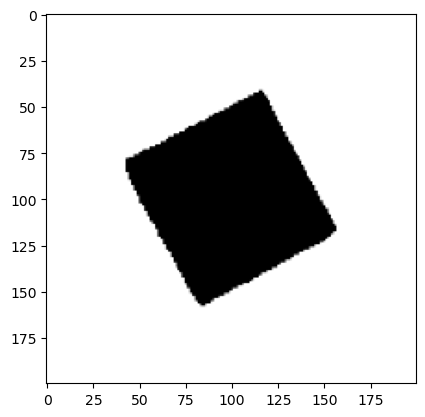

In [13]:
image = Image.open(str('archive (4)/shapes/square/126.png'))
plt.imshow(image, cmap=cm.gray, vmin=0, vmax=255)

In [4]:
'''
model = models.resnet18(pretrained=True)
print(model)
'''

# to restore:
model = ConvNet()

model.load_state_dict(torch.load("square_classifier"))

# print loss
criterion = torch.nn.CrossEntropyLoss()
model.eval()
avg_loss = 0
for x, y in valid_loader:
    output = model(x)
    loss = criterion(output.squeeze(1), y.to(torch.float32))
    avg_loss += loss.item()
avg_loss /= len(valid_loader)
print("avg_loss", avg_loss)
print(model)

avg_loss 0.09285224167057309
ConvNet(
  (conv1): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=320000, out_features=2, bias=True)
)


In [5]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 3
conv_layers


In [6]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [7]:
# Apply transformation on the image, Add the batch size, and load on GPU
image = transform(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

Image shape before: torch.Size([1, 200, 200])
Image shape after: torch.Size([1, 1, 200, 200])


In [8]:
print(image.shape)
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

torch.Size([1, 1, 200, 200])
3
torch.Size([1, 12, 200, 200])
torch.Size([1, 20, 200, 200])
torch.Size([1, 32, 200, 200])


In [9]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(200, 200)
(200, 200)
(200, 200)


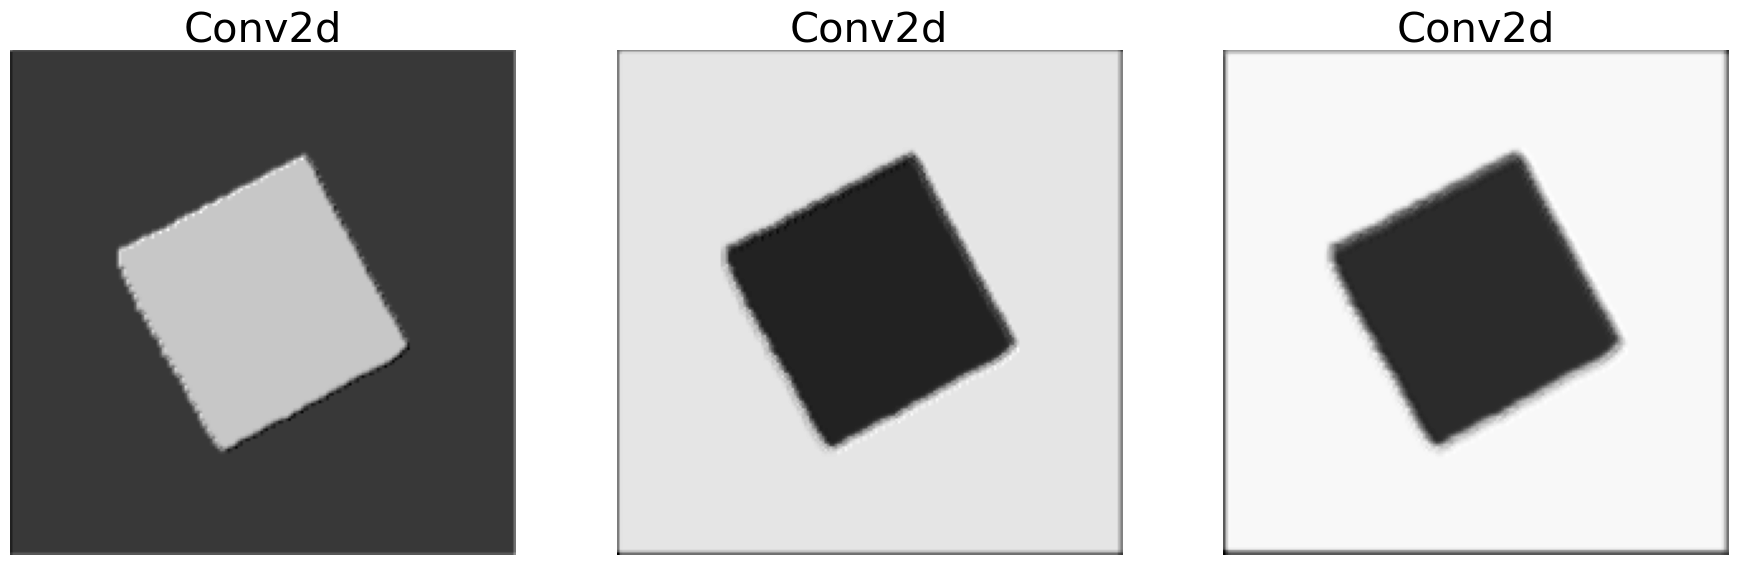

In [15]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i], cmap=cm.gray)
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

In [ ]:
# todo: get this to plot all feature maps
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

In [ ]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i], cmap=cm.gray)
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')